In [1]:
# Importing all of the necessary packages
import os
import copy
import string

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision
from torchvision import transforms, datasets
from skimage import io, transform

from tqdm import tqdm
from sacred import Experiment
from sacred.observers import FileStorageObserver

In [2]:
class ImageDataset(Dataset):
    # Dataset class for our images

    def __init__(self, data_dir="Braille Dataset/"):
        # Initialization of data directory and list of all of the paths to each image in the data
        self.data_dir = data_dir
        self.image_path_list = sorted(self._find_files(data_dir))

    def __len__(self):
        '''
        Function to get the length of the dataset
        '''
        return len(self.image_path_list)

    def __getitem__(self, index):
        '''
        Function to be able to select images and corresponding labels from the dataset
        '''
        # Convert string labels to integers
        labels = []
        for path in self.image_path_list:
            label = path.replace(self.data_dir + 'sorted_data/', '')[0]
            labels.append(label)
        # Creating a set of all possible labels for our task
        labels = sorted(list(set(labels)))
        # Creating a dictionary that maps labels to integers
        labels2tensor = {label: labels.index(label) for label in labels}

        image_path_ex = self.image_path_list[index]
        label_ex = image_path_ex.replace(self.data_dir + 'sorted_data/', '')[0]
        # Load image
        image_ex = io.imread(image_path_ex)
        # Normalize image (make values between 0 and 1)
        image_ex = image_ex / np.max(image_ex)
        # Function to transform the images to float32 tensors
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.ConvertImageDtype(dtype=torch.float32)])
        # Transform image and get label's corresponding integer
        image_ex = transform(image_ex)
        label_ex = labels2tensor[label_ex]

        return image_ex, label_ex

    def prep_data(self, data_dir):
        '''
        Function to organize the letter images into one directory for each letter
        - this function assumes the dataset was downloaded and unzipped in the same directory as the python scripts
        '''
        os.makedirs(f'{data_dir}/sorted_data/', exist_ok=True)  # Creates a sorted_data directory within Braille Dataset directory
        for root, dirs, files in os.walk(f'{data_dir}/Braille Dataset'):
            for file in tqdm(sorted(files)):
                if file.endswith('.jpg'):
                    os.makedirs(f'{data_dir}/sorted_data/{file[0]}/',
                                exist_ok=True)  # Adds a directory for each letter of the alphabet
                    copyfile(f'{root}/{file}',
                             f'{data_dir}/sorted_data/{file[0]}/{file}')  # Adds each letter image to it's corresponding directory

    def _find_files(self, directory):
        '''
        Function to get all files in data directory
        '''
        image_path_list = []
        sorted_dir = os.path.join(directory, "sorted_data")
        if not os.path.isdir(sorted_dir):
            print("Processing the data.")
            self.prep_data(self.data_dir)
        for letter in string.ascii_lowercase:
            curr_dir = os.path.join(sorted_dir, letter)
            image_path_list += [os.path.join(curr_dir, f) for f in os.listdir(curr_dir)]
        return image_path_list

## Explanation of Model Architecture

Since we were dealing with convolutional classifier for this task we started out with a basic model using 2 convolutional layers to process the image and 1 linear layer for classification. Then, to improve our model we started adding more convolutional and linear layers, settling on 3 convolutional and 3 linear layers. Next, we expoerimented with other functionalities within the convolutional layers such as Batch Normalization, Max Pooling and Dropout. After our experiments we found that Max Pooling for all convolutional layers performed best, while Batch Normalization and Dropout did not improve performance for this case. Lastly, we wanted to find the perfect number of channels, kernel size, padding, and max pooling size for the convolutional layers and number of dimensions for the linear layers. We found that performance improved as we increased the size of the layers, but only up to a certain point and performance also seemed to be best when theses values were all factors of 4. For all of the other values within the convolutional layers, we experimented with many values, but our intial ones of 5 and 3 for kernel size, 2 for max pooling kernel size, and 2 for padding performed best.

In [3]:
class CNNClassif(nn.Module):
    """Convolutional neural network classifier for Braille letter images"""
    def __init__(self, num_channels1=16, num_channels2=32, num_channels3=64,
                 num_lin_channels1=128, num_lin_channels2=64, num_classes=26):
        super(CNNClassif, self).__init__()
        # Convolutional channel values
        self.num_channels1 = num_channels1
        self.num_channels2 = num_channels2
        self.num_channels3 = num_channels3
        # Linear dimension values
        self.num_lin_channels1 = num_lin_channels1
        self.num_lin_channels2 = num_lin_channels2
        # Number of classes
        self.num_classes = num_classes
        
        # Convolutional layer 1 with ReLU actication and Max Pooling
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        # Convolutional layer 2 with ReLU actication and Max Pooling
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        # Convolutional layer 3 with ReLU actication and Max Pooling
        self.cnn_layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, kernel_size=3, padding=2), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        # Linear layer 1 with ReLU activation
        self.linear_layer1 = nn.Sequential(nn.Linear(num_channels3*4*4, num_lin_channels1), nn.ReLU())
        # Linear layer 2 with ReLU activation
        self.linear_layer2 = nn.Sequential(nn.Linear(num_lin_channels1, num_lin_channels2), nn.ReLU())
        # Linear layer 3 with ReLU activation
        self.linear_layer3 = nn.Sequential(nn.Linear(num_lin_channels2, num_classes), nn.ReLU())
        
    def forward(self, x):
        '''
        Forward pass of the model to pass the batches through each layer of the model
        '''
        w = self.cnn_layer1(x)
        y = self.cnn_layer2(w)
        z = self.cnn_layer3(y)
        z2 = z.reshape(z.shape[0], -1)
        lin1 = self.linear_layer1(z2)
        lin2 = self.linear_layer2(lin1)
        out = self.linear_layer3(lin2)
        return out 

def init_weights(m):
    '''
    Function to initialize the weights of the model
    '''
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

We wrapped our code in a sacred experiment in order to test different (hyper)parameters.
The results are saved locally in `runs/` directory.

In [4]:
# Creation of a sacred experiment
ex = Experiment('braille_cnn', interactive=True)
ex.observers.append(FileStorageObserver('runs'))

@ex.config
def config():
    """Configuration of the Braille Image Classifier experiment."""
    # Random seed value
    seed = 0
    # Number of images per batch
    batch_size = 8
    # Maximum number of training epochs
    num_epochs = 50
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    # Learning rate
    learning_rate = 0.01
    # Patience value: maximum number of epochs to continue training without improvement of validation accuracy
    # - Used to implement early stopping
    patience = 10
    # Number of convolutional channels for layers 1-3
    num_channels1 = 32
    num_channels2 = 64
    num_channels3 = 128
    # Number of dimensions for the last 2 linear layers
    num_lin_channels1 = 128
    num_lin_channels2 = 64
    
    
@ex.capture
def training_cnn_classifier(model, train_dataloader, val_dataloader, num_epochs, loss_fn,
                            learning_rate, patience, verbose=True):
    '''
    Function to train the CNN classifier
    - Parameters:
        - model: instantiation of the CNN
        - train_dataloader: training dataloader
        - val_dataloader: validation dataloader
        - num_epochs: maximum number of epochs
        - loss_fn: loss function
        - learning_rate: learning rate
        - patience: patience value (maximum number of epochs to continue training without validation accuracy improvement before early stoppage)
    - Returns:
        - model_tr: our model with the adjusted parameters after training
        - loss_all_epochs: A list containing the loss value for each epoch
    '''
    
    # Create a deepcopy of the model and commence training
    model_tr = copy.deepcopy(model)
    model_tr.train()
    
    # Define the optimizer to use in the model
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize the list that will contain all loss values and set no_improve early stopping variable to 0
    loss_all_epochs = []
    val_loss_all = []
    no_improve = 0  # value to track for how many epochs validation accuracy is not improving
    
    # Training loop
    for epoch in range(num_epochs):
        # Set loss for the current epoch to 0
        loss_current_epoch = 0
        
        # Iterate through all batches for a given epoch
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # Run the forward pass of the model and compute the loss based on the obtained y_pred predication and correct labels
            y_pred = model_tr.forward(images)
            loss = loss_fn(y_pred, labels)
            
            # Run backward pass of the model to adjust the weights using our defined optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the epoch loss with the loss from the currect batch
            loss_current_epoch += loss.item()

        # Append the average loss over the entire epoch to the loss_all_epochs list
        loss_all_epochs.append(loss_current_epoch / (batch_index + 1))
        # Run the model on the validation data
        val_accuracy, val_loss = eval_cnn_classifier(model_tr, eval_dataloader=val_dataloader, loss_fn=loss_fn)
        val_loss_all.append(val_loss)
        
        # Early stopping implementation to check if validation accuracy is improving
        if epoch == 0:
            best_acc = val_accuracy
        elif val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model_tr.state_dict(), 'test_model.pt')
            no_improve = 0
        else:
            no_improve += 1
        if verbose:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_current_epoch/(batch_index + 1):.4f}')
            print(f'-----> Validation Accuracy: {val_accuracy:.3f}%')
            ex.log_scalar('loss', loss_current_epoch, step=epoch+1)
        
        # When the number of epochs without validation accuracy improvement is greater than our patience value we end training
        if no_improve >= patience:
            break
        
    return model_tr, loss_all_epochs, val_loss_all

@ex.capture
def eval_cnn_classifier(model, eval_dataloader, loss_fn):
    '''
    Function to run evaluation on the classifier
    - Parameters:
        - model: model
        - eval_dataloader: evaluation dataloader; could be validation or test data
    - Returns:
        - accuracy: accuracy of the model on the evaluation data
    '''
    
    # Set model into evaluation mode, since we won't be adjusting any weights here
    model.eval() 

    # While disabling the gradient calculation (since we are not training), run the model on the eval_dataloader
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            loss = loss_fn(y_predicted, labels)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
            # Update the epoch loss with the loss from the currect batch
            total_loss += loss.item()
    
    accuracy = 100 * correct / total
    
    return accuracy, total_loss


@ex.main
def run(seed, batch_size, num_epochs,
        num_channels1, num_channels2, num_channels3,
        num_lin_channels1, num_lin_channels2):
    '''
    Function to run all of our data preprocessing, training, and evaluation
    - Parameters:
        - seed: Random seed
        - batch_size: batch size
        - num_epochs: maximum number of epochs
        - num_channels1: number of channels for 1st convolutional layer
        - num_channels2: number of channels for the 2nd convolutional layer
        - num_channels3: number of channels for the 3rd convolutional layer
        - num_lin_channels1: number of dimensions for the second linear layer 
        - num_lin)channels2: number of dimensions for the third and final linear layer
    '''

    # Instantiating the dataset
    dataset = ImageDataset()
    # Splitting the dataset
    split_data = random_split(dataset, [1248, 156, 156], generator=torch.Generator().manual_seed(seed))
    train_data, val_data, test_data = split_data

    # Creating the dataloaders for each split of our dataset
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    # Printing the number of classes, batch shape and number of batches for training
    num_classes = len(list(set([datapoint[1] for datapoint in train_data])))
    print("Number of classes: ", num_classes)
    batch_data, batch_name =  next(iter(train_dataloader))
    print(f'Batch shape [batch_size, image_shape]: {batch_data.shape}')
    print('Number of batches:', len(train_dataloader))

    print("== Initializing model...")
    model = CNNClassif(num_channels1, num_channels2, num_channels3,
                       num_lin_channels1, num_lin_channels2, num_classes)
    torch.manual_seed(seed)
    model.apply(init_weights)
    num_params = sum(p.numel() for p in model.parameters())
    ex.log_scalar('number_of_params', num_params)
    print(model)

    print("== Training...")
    model, loss_total, val_loss_total = training_cnn_classifier(model, train_dataloader, val_dataloader)
    ex.add_artifact('test_model.pt')

    plt.plot(loss_total, label='Training loss')
    plt.plot(val_loss_total, label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('loss.png')
    plt.legend()
    ex.add_artifact('loss.png')

    print("== Evaluating...")
    # Instantiating and loading the best model checkpoint from training so we can run evaluation on it
    model_eval = CNNClassif(num_channels1, num_channels2, num_channels3,
                            num_lin_channels1, num_lin_channels2, num_classes)
    model_eval.load_state_dict(torch.load('test_model.pt'))
    accuracy, loss = eval_cnn_classifier(model_eval, test_dataloader)
    ex.log_scalar('accuracy', accuracy)
    
    return f'{accuracy:.3f}%'

INFO - braille_cnn - Running command 'run'
INFO - braille_cnn - Started run with ID "78"


Number of classes:  26
Batch shape [batch_size, image_shape]: torch.Size([8, 3, 28, 28])
Number of batches: 156
== Initializing model...
CNNClassif(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer1): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear_layer2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (l

INFO - braille_cnn - Result: 92.308%
INFO - braille_cnn - Completed after 0:01:05


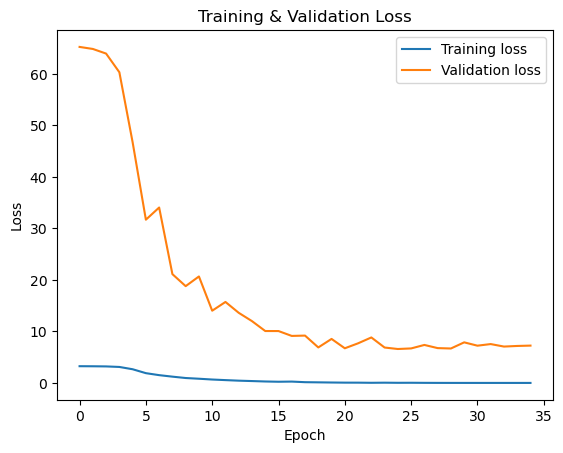

In [5]:
# run the experiment
# no arguments are passed as sacred provides them implicitly from ex.config
ex.run()